## map2loop: Hamersely maps

This notebook reads in three layers from  local or remote sources:  geology polygons, orientation data and fault polylines; and calculates the topological relationships between the different features. Requires compiled cpp code from Vitaliy Ogarko

This all gets fed into successive tolopogical and geometric transfroms that end up feeding into a mdelling engine to make a 3D model 


## Choose map area
1. Run cell below
2. Select map area from drop down menu   
3. Click in next cell and run next cells to define modelling engine run to end using menu:  
   *Cell->Run all below*


In [1]:
import ipywidgets as widgets
import os

# load last saved map area and mdoe engine (if they exist)
if(os.path.isfile('../last_choices.txt')):
    f=open('../last_choices.txt','r')
    contents =f.readlines()
    f.close()
    default_map=contents[0].replace("\n","")
    default_engine=contents[1].replace("\n","")
else:
    default_map='test_data3'
    default_engine='loopstructural'

map_choice=widgets.Dropdown(
    options=['test_data3','Turner_Syncline'],
    value=default_map,
    description='Map area:',
    disabled=False,
)
display(map_choice)

Dropdown(description='Map area:', options=('test_data3', 'Turner_Syncline'), value='test_data3')

In [2]:
test_data_name=map_choice.value
print(test_data_name)


test_data3


## Choose model engine
1. Run cell below
2. Select modelling engine from drop down menu   
3. Click in next cell and run to end using menu: *Cell->Run all below* 

In [3]:
engine_choice=widgets.Dropdown(
    options=['geomodeller', 'gempy','loopstructural','noddy','null'],
    value=default_engine,
    description='Modeller:',
    disabled=False,
)
display(engine_choice)

Dropdown(description='Modeller:', index=1, options=('geomodeller', 'gempy', 'loopstructural', 'noddy', 'null')…

In [4]:
workflow={'model_engine':engine_choice.value} 
print(workflow['model_engine'])
# save last map and engine choices
f=open('../last_choices.txt','w') 
ostr=str(map_choice.value)+'\n'+str(engine_choice.value)+'\n'
f.write(ostr)
f.close()

gempy


In [5]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import sys
import stat
import functools 
import operator  
import matplotlib
import networkx as nx
import rasterio
from matplotlib import pyplot
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from map2loop import m2l_utils
from map2loop import m2l_topology
from map2loop import m2l_geometry
from map2loop import m2l_interpolation
from map2loop import m2l_export
from map2loop import m2l_map_checker
import time
import shutil
%matplotlib inline
t0 = time.time()


## Load config file

In [6]:
test_data_path='../'+test_data_name+'/'

os.chdir(test_data_path)
%run -i "m2l_config.py"
#%run -i "m2l_config_remote.py"
print(os.getcwd())

bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
bbox=(minx,miny,maxx,maxy)


Default parameters loaded from ../test_data3/m2l_config.py:
#ROI

step_out=0.1   #padding arounf dtm to ensure reprojected dtm covers target area (in degrees)
inset=0      #unused??

minx=500057  #region of interest coordinates in metre-based system (or non-degree system)
maxx=603028
miny=7455348
maxy=7567953
model_top=1200
model_base=-3200

#PATHS

local_paths=True       #flag to use local or WFS source for data inputs (True = local)
import os

last=os.path.split(os.getcwd())[1]

test_data_path='../'+last+'/'

data_path='../source_data/'

geology_file='hams2_geol.shp'   #input geology file (if local)
fault_file='GEOS_GEOLOGY_LINEARSTRUCTURE_500K_GSD.shp' #input fault file (if local)
structure_file='hams2_structure.shp' #input bedding orientation file (if local)
mindep_file='mindeps_2018.shp' #input mineral deposit file (if local)

#CRS

src_crs = {'init': 'epsg:4326'}  # coordinate reference system for imported dtms (geodetic lat/long WGS84)
dst_crs = {'init': 'epsg:28350'} # coordina

In [7]:
# opportunity to second guess config file or add extra parameters not yet in config file...

fold_decimate=2         

fault_decimate=0

contact_decimate=5

orientation_decimate=0

use_interpolations=True       #use interpolated dips/contacts as additional constraints

use_fat=True                   #use fold axial trace orientation hints

pluton_form='domes'

fault_dip=90

min_fault_length=5000

compute_etc=False

spacing=500   #grid spacing in metres of interpolation points


local_paths=True

#################################
# There are many alternative datasets that 
# can be extracted from the input data, 
# and many choices of possible input data
#
# These flags define what the actual workflow 
# will be for this experiment, based partly 
# on which (if any) modelling engine is used
#
#############################################


if(workflow['model_engine']=='geomodeller'):
    workflow.update( {'seismic_section':False,
          'cover_map':False,
          'near_fault_interpolations':True,
          'fold_axial_traces':False,
          'stereonets':True,
          'formation_thickness':True,
          'polarity':False,
          'strat_offset':True,
          'contact_dips':True} )
elif(workflow['model_engine']=='loopstructural'):
    workflow.update( {'seismic_section':False,
          'cover_map':False,
          'near_fault_interpolations':False,
          'fold_axial_traces':True,
          'stereonets':True,
          'formation_thickness':True,
          'polarity':False,
          'strat_offset':False,
          'contact_dips':True} )
elif(workflow['model_engine']=='gempy'):
    workflow.update( {'seismic_section':False,
          'cover_map':False,
          'near_fault_interpolations':False,
          'fold_axial_traces':True,
          'stereonets':False,
          'formation_thickness':False,
          'polarity':False,
          'strat_offset':False,
          'contact_dips':False} )
elif(workflow['model_engine']=='noddy'):
    workflow.update( {'seismic_section':False,
          'cover_map':False,
          'near_fault_interpolations':False,
          'fold_axial_traces':False,
          'stereonets':False,
          'formation_thickness':False,
          'polarity':False,
          'strat_offset':False,
          'contact_dips':False} )
else:
    workflow.update( {'seismic_section':False,
          'cover_map':False,
          'near_fault_interpolations':False,
          'fold_axial_traces':False,
          'stereonets':True,
          'formation_thickness':True,
          'polarity':False,
          'strat_offset':True,
          'contact_dips':False} )
    


# no cover info so no need load cover layers
if(not workflow['cover_map']):
    dtb=0
    dtb_null=0
else:
    dtb_grid=data_path+'young_cover_grid.tif' #obviously hard-wired for the moment
    dtb_null='-2147483648' #obviously hard-wired for the moment
    cover_map_path=data_path+'Young_Cover_FDS_MGA_clean.shp' #obviously hard-wired for the moment
    dtb_clip=output_path+'young_cover_grid_clip.tif' #obviously hard-wired for the moment
    cover_dip=10 # dip of cover away from contact
    spacing=5000 # of contact grid in metres


## First we test to see if we have access to the online data we need


In [8]:
geol=gpd.read_file('../source_data/hamms_roi.shp', bbox=bbox)
display(geol)
display(bbox)


,Id,geometry
0,0,"POLYGON ((500057.492 7567446.542, 603028.250 7..."


(500057, 7455348, 603028, 7567953)

In [9]:
loopwfs=m2l_utils.have_access("geo.loop-gis.org")
ga=m2l_utils.have_access("services.ga.gov.au")
if(not local_paths and not loopwfs):
    raise NameError('map2loop error: No access to remote map server')
if(not (loopwfs & ga)):
    local_paths=True
    net=False
    print('using local paths')
else:
    net=True

available: geo.loop-gis.org
available: services.ga.gov.au


##  Check Map for valid input files   
   
### Checks for:   
- Files exist
- Requred fields
- No NaN/blanks in required fields
- Sufficient orientation data
- LineString/PolyLines for faults (i.e. not MultiLineStrings/MultiPolylines), if found splits into unique ID polylines
- Commas in unit code (maybe should check in groups and alt groups??

### Should also check for:   
- Significantly overlapping polygons
- Faults that should be joined (c.f. FracG code)
- Orientations near contacts that make no sense (i.e. strike is at high angle to contact tangent)



In [10]:
m2l_map_checker.check_map(structure_file,geology_file,fault_file,mindep_file,tmp_path,bbox,c_l,dst_crs,local_paths)

No errors found


## Display stereonets of bedding by formations and group to see how we can combine them later

All observations n= 121
groups ['Hamersley Group' 'Fortescue Group' 'A-mgn-PRK' 'Turee Creek Group'
 'A-b-PRK' 'A-mgn-PMI' 'A-s-PMI' 'A-s-PRK' 'Shingle Creek Group'
 'Wyloo Group'] 
codes ['A-HAm-cib' 'A-FOp-bs' 'A-HAS-xsl-ci' 'P_-HAb-cib' 'P_-HAj-xci-od'
 'A-mgn-PRK' 'A-FOh-xs-f' 'A-FOo-bbo' 'A-FO-od' 'A-HAd-kd' 'A-FOj-xs-b'
 'P_-TKa-xs-k' 'P_-HAo-ci' 'P_-HAw-fr' 'A-FO-xo-a' 'A-b-PRK' 'A-FOr-b'
 'A-FOu-bbo' 'P_-TK-s' 'A-mgn-PMI' 'A-s-PMI' 'A-s-PRK' 'P_-SKq-stq'
 'P_-WYm-sp' 'P_-WYa-st' 'P_-WYd-kd' 'P_-TKo-stq' 'P_-TKk-sf' 'P_-SKb-bb']


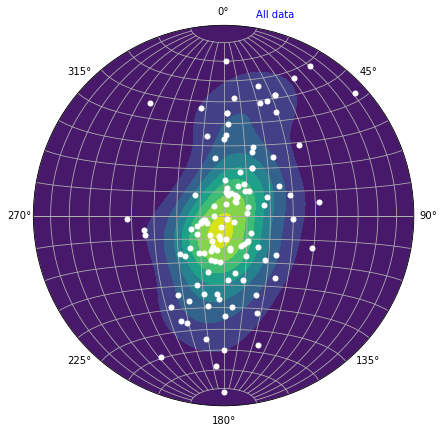

----------------------------------------------------------------------------------------------------------------------
Hamersley Group observations n= 42
strike/dip of girdle 20.08147699007361 / 88.66632104537987


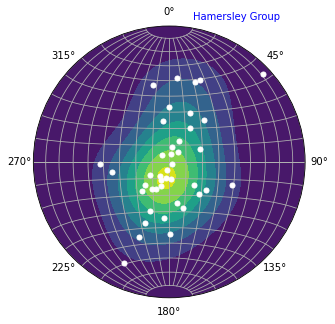

----------------------------------------------------------------------------------------------------------------------
Fortescue Group observations n= 62
strike/dip of girdle 15.23005169069387 / 85.89398810068597


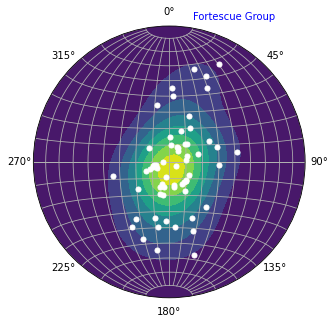

----------------------------------------------------------------------------------------------------------------------
A-mgn-PRK observations has no observations
----------------------------------------------------------------------------------------------------------------------
Turee Creek Group observations n= 5
strike/dip of girdle 11.915403519353958 / 70.98306185852391


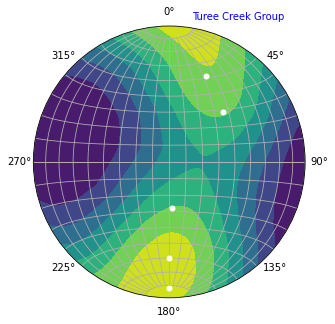

----------------------------------------------------------------------------------------------------------------------
A-b-PRK observations n= 1
strike/dip of girdle 184.05850420603332 / 43.772682082926686


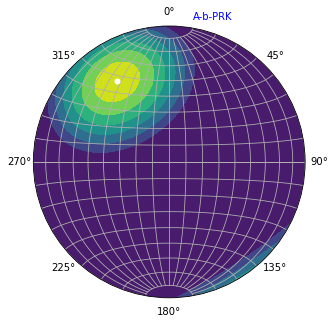

----------------------------------------------------------------------------------------------------------------------
A-mgn-PMI observations n= 1
strike/dip of girdle 5.0 / 90.0


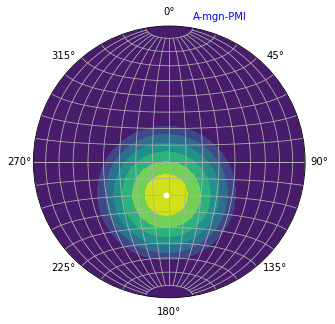

----------------------------------------------------------------------------------------------------------------------
A-s-PMI observations n= 2
strike/dip of girdle 213.72215814957758 / 69.7878280813251


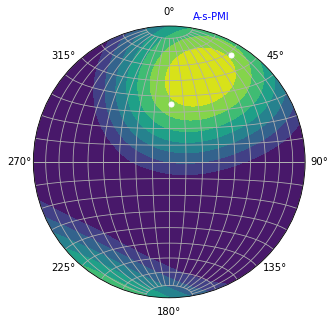

----------------------------------------------------------------------------------------------------------------------
A-s-PRK observations has no observations
----------------------------------------------------------------------------------------------------------------------
Shingle Creek Group observations n= 5
strike/dip of girdle 4.713393856057394 / 86.06935108961152


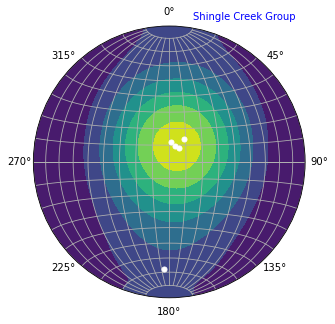

----------------------------------------------------------------------------------------------------------------------
Wyloo Group observations n= 3
strike/dip of girdle 184.32867724945046 / 85.36563208756644


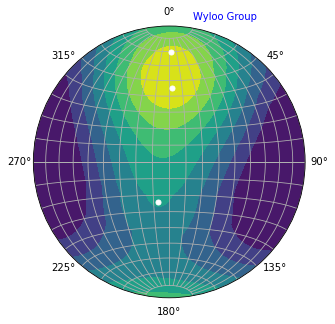

In [10]:
geology = gpd.read_file(geology_file,bbox=bbox)

geology[c_l['g']].fillna(geology[c_l['g2']], inplace=True)
geology[c_l['g']].fillna(geology[c_l['c']], inplace=True)

orientations = gpd.read_file(structure_file,bbox=bbox)
if(len(orientations)<2):
    raise NameError('Not enough orientations to complete calculations (need at least 2)')
group_girdle=m2l_utils.plot_bedding_stereonets(orientations,geology,c_l)


## Test code to automatically create super_groups and use_group3

In [11]:
super_groups,use_gcode3=m2l_topology.super_groups_and_groups(group_girdle,tmp_path)


,plunge,bearing,num orientations
Fortescue Group,4.106012,285.230052,62
Hamersley Group,1.333679,290.081477,42
Turee Creek Group,19.016938,281.915404,5
Shingle Creek Group,3.930649,274.713394,5
Wyloo Group,4.634368,94.328677,3
A-s-PMI,20.212172,123.722158,2
A-b-PRK,46.227318,94.058504,1
A-mgn-PMI,0.000000,275.000000,1
A-mgn-PRK,-999.000000,-999.000000,0
A-s-PRK,-999.000000,-999.000000,0


---------------------------------


,Super_Group,l,m,n
Group,,,,
Fortescue Group,Super_Group_0,-6.908735e-02,1.880954e-02,0.997433
Hamersley Group,Super_Group_0,-2.185999e-02,7.991608e-03,0.999729
Turee Creek Group,Super_Group_0,-3.188268e-01,6.727687e-02,0.945422
Shingle Creek Group,Super_Group_0,-6.831715e-02,5.632771e-03,0.997648
Wyloo Group,Super_Group_0,8.056634e-02,-6.098367e-03,0.996731
A-s-PMI,Super_Group_0,2.873640e-01,-1.918085e-01,0.938420
A-b-PRK,Super_Group_1,7.202794e-01,-5.110596e-02,0.691799
A-mgn-PMI,Super_Group_0,-6.099933e-17,5.336750e-18,1.000000
A-mgn-PRK,Super_Group_2,9.755283e-01,1.545085e-01,0.156434


['Fortescue_Group',
 'Hamersley_Group',
 'Turee_Creek_Group',
 'Shingle_Creek_Group',
 'Wyloo_Group',
 'A_s_PMI',
 'A_b_PRK',
 'A_mgn_PMI',
 'A_mgn_PRK',
 'A_s_PRK']

{'Super_Group_0', 'Super_Group_1', 'Super_Group_2', 'Super_Group_8'}

[['A-s-PRK'],
 ['Fortescue Group',
  'Hamersley Group',
  'Turee Creek Group',
  'Shingle Creek Group',
  'Wyloo Group',
  'A-s-PMI',
  'A-mgn-PMI'],
 ['A-b-PRK'],
 ['A-mgn-PRK']]

## Decide on super groups and groups
Supergroups define what shall be interpolated as single system   
use_gcode defines which groups we choose to calculate model from  

<font color='red'>The following outputs are the default settings that put all groups as one super_group for orientation interpolation purposes and use_gcode3 defines which groups will actually be modelled If after looking at the stereonets you want to change these defaults, just copy paste the two following lines into the next cell below and edit them as you wish. </font>  

In [12]:

print("super_groups=",super_groups)
print("use_gcode3=",use_gcode3)


super_groups= [['A-s-PRK'], ['Fortescue Group', 'Hamersley Group', 'Turee Creek Group', 'Shingle Creek Group', 'Wyloo Group', 'A-s-PMI', 'A-mgn-PMI'], ['A-b-PRK'], ['A-mgn-PRK']]
use_gcode3= ['Fortescue_Group', 'Hamersley_Group', 'Turee_Creek_Group', 'Shingle_Creek_Group', 'Wyloo_Group', 'A_s_PMI', 'A_b_PRK', 'A_mgn_PMI', 'A_mgn_PRK', 'A_s_PRK']


## Preprocess data to ensure it meets modelling requirements

In [13]:
print('only processing',use_gcode3)

inputs=('')

if(workflow['model_engine'] =='geomodeller'):
    inputs=('invented_orientations','intrusive_orientations','fat_orientations','near_fault_orientations','fault_tip_contacts','contact_orientations')
elif(workflow['model_engine']=='loopstructural'):
    inputs=('invented_orientations','fat_orientations','contact_orientations')
elif(workflow['model_engine']=='gempy'):
    inputs=('invented_orientations','interpolated_orientations','fat_orientations')
elif(workflow['model_engine']=='noddy'):
    inputs=('')

only processing ['Fortescue_Group', 'Hamersley_Group', 'Turee_Creek_Group', 'Shingle_Creek_Group', 'Wyloo_Group', 'A_s_PMI', 'A_b_PRK', 'A_mgn_PMI', 'A_mgn_PRK', 'A_s_PRK']


## Plot geology polygons and bounding box

../source_data/hams2_geol.shp


,OBJECTID_1,OBJECTID,LITHSTRTNO,CODE,UNITNAME,GSWASTATUS,RANK,DESCRIPTN,PARENTCODE,PARENTNAME,...,MIN_AGE_MA,MINUNCERTY,MAX_AGE_DA,MIN_AGE_DA,EXTRACT_DA,SHAPE_Leng,ORIG_FID,Shape_Le_1,Shape_Area,geometry
0,1,1,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,"Chert, banded iron-formation, mudstone, and si...",A-HAL-xci-kd,"Hamersley Group, lower",...,2597,5,Inferred,Isotopic,2014-12-04,0.078975,0,0.078975,0.000125,"POLYGON ((520335.610 7461468.599, 520278.380 7..."
1,2,2,4144,A-FOp-bs,Pyradie Formation,Formal,Formation,Pyroxene spinifex-textured basaltic flows and ...,A-FO-xb-s,Fortescue Group,...,2718,None,Inferred,Inferred,2014-12-04,2.091002,1,2.091002,0.017331,"POLYGON ((553729.401 7465563.870, 553493.270 7..."
2,13,9,4124,A-HAS-xsl-ci,Mount McRae Shale and Mount Sylvia Formation,Informal,Subgroup,"Mudstone, siltstone, chert, banded iron-format...",AP_-HA-xci-sl,Hamersley Group,...,2501,None,Inferred,Inferred,2014-12-04,9.030055,8,8.890599,0.025196,"POLYGON ((609650.041 7528488.698, 609628.980 7..."
3,17,12,4113,P_-HAb-cib,Brockman Iron Formation,Formal,Formation,"Banded iron-formation, chert, mudstone, and si...",P_-HAU-xci-f,"Hamersley Group, upper",...,2451,None,Inferred,Inferred,2014-12-04,5.308226,11,5.308226,0.057164,"POLYGON ((528055.800 7501423.059, 528302.380 7..."
4,28,23,4111,P_-HAj-xci-od,Weeli Wolli Formation,Formal,Formation,"Banded iron-formation (commonly jaspilitic), m...",P_-HAU-xci-f,"Hamersley Group, upper",...,2450,None,Inferred,Inferred,2014-12-04,0.503939,22,0.503939,0.002085,"POLYGON ((492806.271 7548947.940, 493414.600 7..."


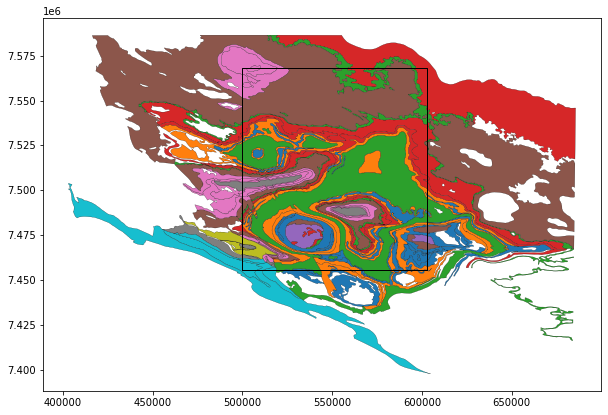

In [15]:
print(geology_file)
geology_ll = gpd.read_file(geology_file,bbox=bbox)

geology_ll[c_l['g']].fillna(geology_ll[c_l['g2']], inplace=True)
geology_ll[c_l['g']].fillna(geology_ll[c_l['c']], inplace=True)
display(geology_ll.head())
base=geology_ll.plot(column=c_l['c'],figsize=(10,10),edgecolor='#000000',linewidth=0.2)
polygon.plot(ax=base, color='none',edgecolor='black')


## Save geology to file as WKT

In [16]:
hint_flag=False # use GSWA strat database to provide relative age hints
sub_geol = geology_ll[['geometry', c_l['o'],c_l['c'],c_l['g'],c_l['u'],c_l['min'],c_l['max'],c_l['ds'],c_l['r1'],c_l['r2']]]
m2l_topology.save_geol_wkt(sub_geol,geology_file_csv, c_l,hint_flag)

186  polygons


## Save mineral deposits to file as WKT
This is not needed by map2loop to build 3D models, but is used by map2model to calculate mineral deposit/topology analyses.

410  points


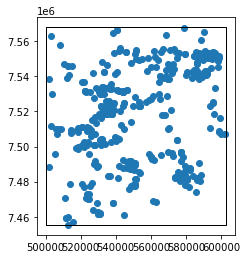

In [17]:
mindep = gpd.read_file(mindep_file,bbox=bbox)

sub_mindep = mindep[['geometry', c_l['msc'],c_l['msn'],c_l['mst'],c_l['mtc'],c_l['mscm'],c_l['mcom']]]
m2l_topology.save_mindep_wkt(sub_mindep,mindep_file_csv, c_l)

base=sub_mindep.plot()
polygon.plot(ax=base, color='none',edgecolor='black')


## Read and save orientations data point data as WKT

121  points


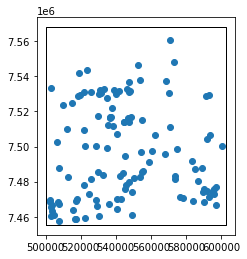

In [18]:
orientations = gpd.read_file(structure_file,bbox=bbox)

sub_pts = orientations[['geometry', c_l['gi'],c_l['d'],c_l['dd']]]

m2l_topology.save_structure_wkt(sub_pts,structure_file_csv,c_l)

base=sub_pts.plot()
polygon.plot(ax=base, color='none',edgecolor='black')


## Plot faults and bounding box

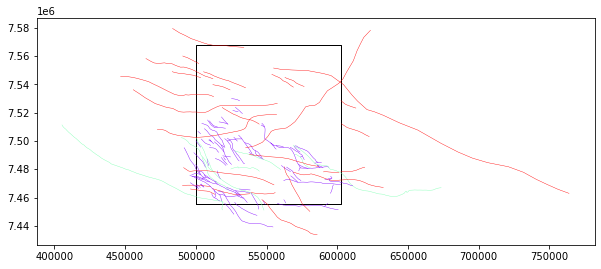

In [19]:
lines_ll=gpd.read_file(fault_file,bbox=bbox)

base2=lines_ll.plot(cmap='rainbow',column=c_l['f'],figsize=(10,10),linewidth=0.4)
polygon.plot(ax=base2, color='none',edgecolor='black')


## Save faults to file as WKT

In [20]:
sub_lines = lines_ll[['geometry', c_l['o'],c_l['f']]]
m2l_topology.save_faults_wkt(sub_lines,fault_file_csv,c_l)

134  polylines


## Create map2model input file

In [21]:
m2l_topology.save_Parfile(m2m_cpp_path,c_l,graph_path,geology_file_csv,fault_file_csv,structure_file_csv,mindep_file_csv,minx,maxx,miny,maxy,500.0,'Fe,Cu,Au,NONE')


## Calculate topology

In [22]:
import subprocess
import platform
os.chdir(m2m_cpp_path)
print(os.getcwd())
#%system map2model.exe Parfile
if(platform.system()=='Windows'):
    subprocess.run(["map2model.exe", "Parfile"])
else:
    subprocess.run(["./map2model", "Parfile"])

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\m2m_cpp


## Simple network graph of the geology with legend

0    'A-HAm-cib'
1    'A-FOp-bs'
2    'A-HAS-xsl-ci'
3    'P_-HAb-cib'
4    'P_-HAj-xci-od'
5    'A-mgn-PRK'
6    'A-FOh-xs-f'
7    'A-FOo-bbo'
8    'A-FO-od'
9    'A-HAd-kd'
10    'A-FOj-xs-b'
11    'P_-TKa-xs-k'
12    'P_-HAo-ci'
13    'P_-HAw-fr'
14    'A-FO-xo-a'
15    'A-b-PRK'
16    'A-FOr-b'
17    'A-FOu-bbo'
18    'P_-TK-s'
19    'A-mgn-PMI'
20    'A-s-PMI'
21    'A-s-PRK'
22    'P_-SKq-stq'
23    'P_-WYm-sp'
24    'P_-WYa-st'
25    'P_-WYd-kd'
26    'P_-TKo-stq'
27    'P_-TKk-sf'
28    'P_-SKb-bb'


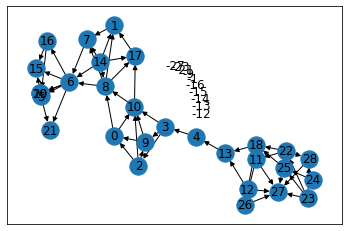

In [23]:
G=nx.read_gml(strat_graph_file,label='id')
selected_nodes = [n for n,v in G.nodes(data=True) if n >=0]
nx.draw_networkx(G, pos=nx.kamada_kawai_layout(G), arrows=True, nodelist=selected_nodes)

nlist=list(G.nodes.data('LabelGraphics'))
nlist.sort()
for no in nlist:
    if(no[0]>=0):
        elem=str(no[1]).replace("{'text':","").replace(", 'fontSize': 14}","")
        #second=elem.split(":").replace("'","")
        print(no[0]," ",elem)

## Process topography, stratigraphy, fold axial traces and faults

### Takes GML file produced by topology code, combines with geology polygons, structure points and dtm to create 3D model in gempy.<br><br>

Limitations:  no dykes, no sills. Sills require us to assign a unique surface to each instance of a sill (sill between units A and B needs to be different from sill of same age and strat codes as one found between E and F). Dykes via cokriging are really hard without just cookie cutting them in (but that is not our problem!). We are not checking for onlap relationships, which can perhaps been seen by having lots of units from one series adjacent to the youngest surface of the older series. Could also think about interpreting these as faults to introduce conceptual uncertainty. All mistakes belong to Mark Jessell, topology code that feeds this system by Vitaliy Ogarko.<br><br>

Geology layer needs to have some unique strat code or text, some group code or text to function<br>
Structure layer needs dip/dip direction<br>




In [24]:
os.chdir('../map2loop')

print(os.getcwd())

#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:80% !important; }</style>"))

sys.path.insert(0,"../..")
print(os.getcwd())


C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop
C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


## Next we define an area of interest and some other basic stuff

In [25]:
print(os.getcwd())

bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
bbox=(minx,miny,maxx,maxy)

step_out=0.045 #add (in degrees) so edge pixel from dtm reprojection are not found


C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


## Download and reproject the appropriate SRTM data
mj: Getting this from GA, but could also get from Hawaii

C:\Users\00073294\Anaconda3\envs\loop\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


116.9555521867685 118.0503484485386 -23.055227990891293 -21.94491765252865


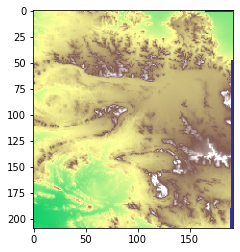

In [26]:
polygon_ll=polygon.to_crs(src_crs)

minlong=polygon_ll.total_bounds[0]-step_out
maxlong=polygon_ll.total_bounds[2]+step_out
minlat=polygon_ll.total_bounds[1]-step_out
maxlat=polygon_ll.total_bounds[3]+step_out

print(minlong,maxlong,minlat,maxlat)
if(((not os.path.exists(dtm_file)) or (not local_paths)) and net):    
    m2l_utils.get_dtm(dtm_file, minlong,maxlong,minlat,maxlat)
    geom_rp=m2l_utils.reproject_dtm(dtm_file,dtm_reproj_file,src_crs,dst_crs)

dtm = rasterio.open(dtm_reproj_file)
pyplot.imshow(dtm.read(1), cmap='terrain',vmin=0,vmax=1000)
pyplot.show()

## Load stratigraphy graph and create list of series (aka groups)
mj: The choice of what constitutes basic unit and what a group of units is hard-wired at the moment, but could be altered to any pair. Not even sure we need two levels but it seemed like a good idea at the time. Note that this needs the arcgis plugin version of the topology code (for now) as it seperates the different sub graphs. Text outputs list alternate topologies for series and surfaces, which if confirmed by comapring max-min ages will be a nice source of uncertainty.

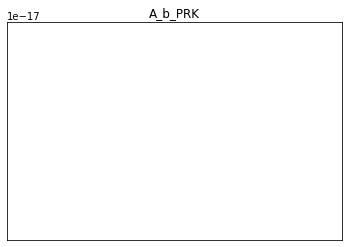

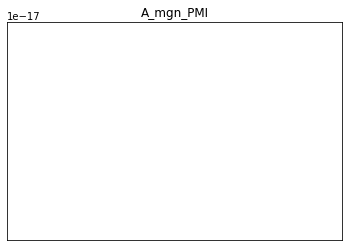

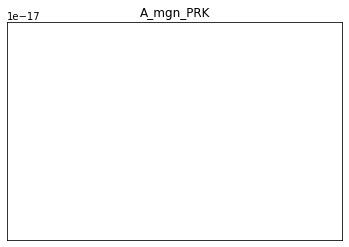

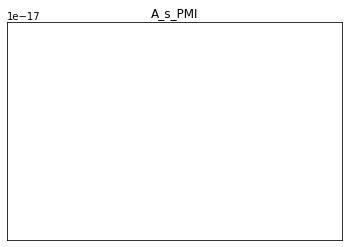

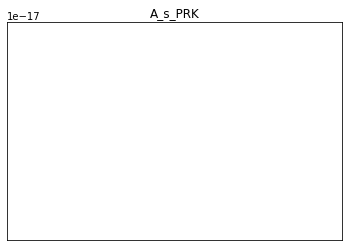

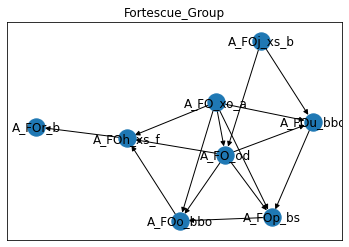

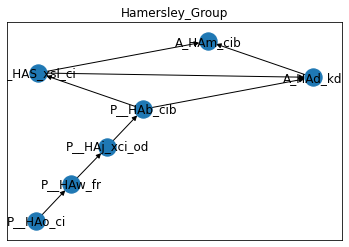

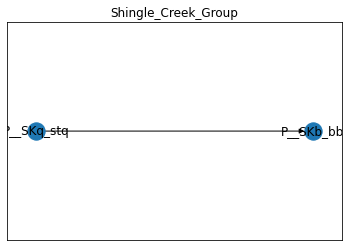

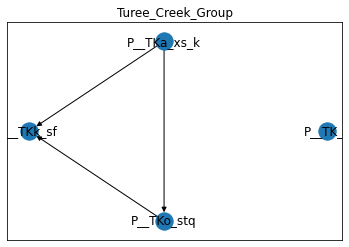

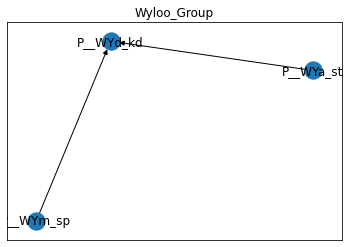

In [27]:
groups,glabels,G = m2l_topology.get_series(strat_graph_file,'id')
m2l_topology.save_units(G,tmp_path,glabels)

## Load geology & structure data
Currently loading from local files, but could load geology from WFS server at GSWA EXCEPT that the WFS online map has less fields that the zipped shapefiles. Go figure. We don't use fault layer at the moment (except for Vitaliy's topology code) but same logic applies in terms of where to get it from. Already have fault/strat relationships and once we have fault/fault relationships will start to include faults in models.

../source_data/GEOS_GEOLOGY_LINEARSTRUCTURE_500K_GSD.shp


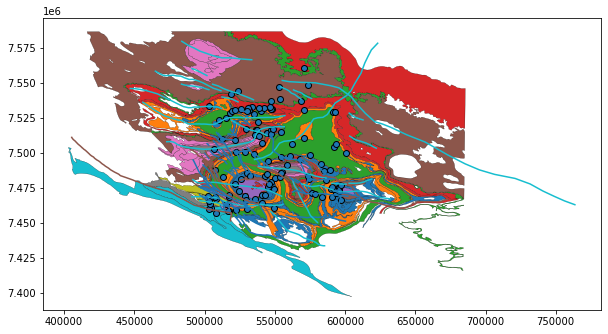

In [28]:
# Extract point data from structure & geology layers for modelling
##First we readin the structure and map from shapefiles, or wherever...

bbox=(minx,miny,maxx,maxy)
geology = gpd.read_file(geology_file,bbox=bbox)
geology[c_l['g']].fillna(geology[c_l['g2']], inplace=True)
geology[c_l['g']].fillna(geology[c_l['c']], inplace=True)


structure = gpd.read_file(structure_file,bbox=bbox)
structure.crs=dst_crs
print(fault_file)
faults = gpd.read_file(fault_file,bbox=bbox)
faults.crs=dst_crs

sub_pts = structure[['geometry',c_l['d'],c_l['dd'],c_l['sf']]] 

base=geology.plot(column=c_l['c'],figsize=(10,10),edgecolor='#000000',linewidth=0.2)
sub_pts.plot(ax=base,edgecolor='black')
faults.plot(ax=base, column=c_l['f'],edgecolor='black')

## Clip geology, faults, structures and map geology to structures

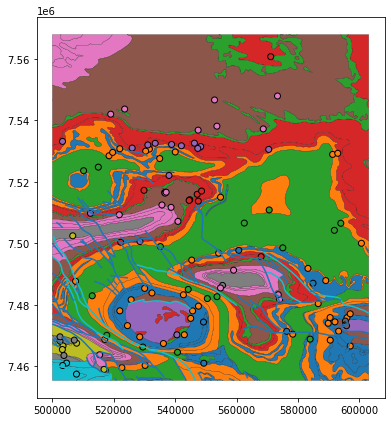

In [29]:
geology = m2l_utils.explode(geology)
geology.crs = dst_crs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
structure_code = gpd.sjoin(sub_pts, geology, how="left", op="within")

y_point_list = [miny, miny, maxy, maxy, miny]
x_point_list = [minx, maxx, maxx, minx, minx]

bbox_geom = Polygon(zip(x_point_list, y_point_list))

polygo = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
#display(polygo.geometry)
is_bed=structure_code[c_l['sf']].str.contains(c_l['bedding'], regex=False) 
    
all_beds = structure_code[is_bed]

if(workflow['fold_axial_traces']):
    all_folds=faults[faults[c_l['f']].str.contains(c_l['fold'])]
    folds_clip=m2l_utils.clip_shp(all_folds,polygo)
    if(len(folds_clip)>0):
        folds_clip.to_file(tmp_path+'folds_clip.shp')


all_faults=faults[faults[c_l['f']].str.contains(c_l['fault'])]


geol_clip=gpd.overlay(geology, polygo, how='intersection')
faults_clip=m2l_utils.clip_shp(all_faults,polygo)

structure_clip = m2l_utils.clip_shp(all_beds, polygo)

base = geol_clip.plot(column=c_l['c'],figsize=(7,7),edgecolor='#000000',linewidth=0.2)
faults_clip.plot(ax=base, column=c_l['f'],edgecolor='black')
structure_clip.plot(ax=base, column=c_l['c'],edgecolor='black')


if(c_l['dd']=='strike'):
    structure_clip['azimuth2'] = structure_clip.apply(lambda row: row[c_l['dd']]+90.0, axis = 1)
    c_l['dd']='azimuth2'
    
geol_clip.to_file(tmp_path+'geol_clip.shp')

structure_clip.to_file(tmp_path+'structure_clip.shp')


## Create possible stratigraphy sets per group
mj: <font color='red'>Uses first of each possible set of toplogies per unit and per group, which is arbitrary. </font>On the other hand we are not checking relative ages again to see if this helps reduce ambiguity, which I think it would.

,index,min,max,ave
group_,,,,
Wyloo_Group,0,1799.0,2010.0,1904.5
Shingle_Creek_Group,1,2208.0,2208.0,2208.0
Turee_Creek_Group,2,2208.0,2449.0,2328.5
Hamersley_Group,3,2208.0,2629.0,2418.5
Fortescue_Group,4,2629.0,2780.0,2704.5
A_mgn_PRK,5,2830.0,3500.0,3165.0
A_mgn_PMI,6,2830.0,3500.0,3165.0
A_b_PRK,7,2930.0,3520.0,3225.0
A_s_PMI,8,2930.0,3520.0,3225.0


[]

{-12: 'A_b_PRK',
 -13: 'A_mgn_PMI',
 -14: 'A_mgn_PRK',
 -15: 'A_s_PMI',
 -16: 'A_s_PRK',
 -1: 'Fortescue_Group',
 -9: 'Hamersley_Group',
 -21: 'Shingle_Creek_Group',
 -23: 'Turee_Creek_Group',
 -27: 'Wyloo_Group'}

group choices: 40


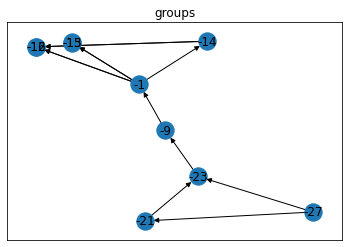

In [30]:
m2l_topology.save_group(G,tmp_path,glabels,geol_clip,c_l)

## Calculate cover depth grid and contacts    
Grid is assumed to be of depth below surface   

Also need to cater for case when we only have grid, no shapefile, so need to add a fake horizontal orientation in the middle of the map at average depth.

In [31]:
if(workflow['cover_map']):

    dtm = rasterio.open(dtm_reproj_file)
    dtb_raw = rasterio.open(dtb_grid)

    cover=gpd.read_file(cover_map_path)

    with fiona.open(cover_map_path, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]

    with rasterio.open(dtb_grid) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta.copy()

    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    with rasterio.open(dtb_clip, "w", **out_meta) as dest:
        dest.write(out_image)  

    dtb = rasterio.open(dtb_clip)
    
    m2l_geometry.process_cover(output_path,dtm,dtb,dtb_null,cover,workflow['cover_map'],cover_dip,bbox,dst_crs,spacing,contact_decimate=3,use_vector=True,use_grid=True)    
    

## Export orientation data in csv  format
mj: Orientation data needs calculated height as file does not provide it, taken from SRTM data already downloaded. To calculate polarity <font color='red'>(WHICH WE DON'T DO YET)</font> we can calculate the dot product of the dip direction of a bedding plane and the vector to that points nearest basal contact node, if  abs(acos(dot product))>90  then right way up?



Added code to not save intrusion orientation data as they won't have associated surfaces if sill...

115 orientations saved to ../test_data3/output/orientations.csv


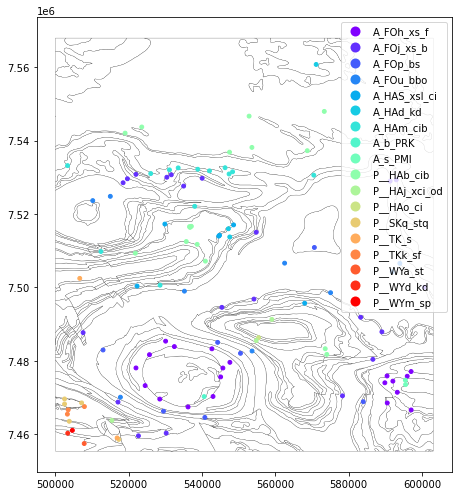

In [32]:
m2l_geometry.save_orientations(structure_clip,output_path,c_l,orientation_decimate,dtm,dtb,dtb_null,workflow['cover_map'])

m2l_utils.plot_points(output_path+'orientations.csv',geol_clip, 'formation','X','Y',True)

## Find those series that don't have any orientation or contact point data  then create arbitrary point for series with no orientation data
Not sure if gempy needs this but geomodeller does. Currently just gives a point dipping 45 degrees to North, but could use dip direction normal to basal surface)

In [33]:
m2l_geometry.create_orientations( tmp_path, output_path, dtm,dtb,dtb_null,workflow['cover_map'],geol_clip,structure_clip,c_l)

extra orientations saved as ../test_data3/output//empty_series_orientations.csv


## Export contact information subset of each polygon to gempy format
mj: Orientation data needs calculated height as file does not provide it, taken from SRTM data already downloaded. Need to reduce number of points whilst retaining useful info (Ranee's job!)'
To calculate which are the basal units contact for a polygon find the polygons which are older than the selected polygon, in the example below the central polygon has relative age 23 so its basal contact is with the polygons whose ages are 26 & 28. If there are no older units for a polygon it has no basal content. We keep every nth node based on the decimate term (simple count along polyline). gempy seems to need at least two points per surface, so we always take the first two points.


<img src='../graphics/base.png'>

In [34]:
ls_dict,ls_dict_decimate=m2l_geometry.save_basal_contacts(tmp_path,dtm,dtb,dtb_null,workflow['cover_map'],geol_clip,contact_decimate,c_l,intrusion_mode)

basal contacts saved allpts= 10902 deci_pts= 2603
saved as ../test_data3/tmp/all_contacts.csv and ../test_data3/tmp/contacts.csv


## Remove all basal contacts that are defined by faults and save to shapefile (no decimation)

In [35]:
m2l_geometry.save_basal_no_faults(tmp_path+'basal_contacts.shp',tmp_path+'faults_clip.shp',ls_dict,10,c_l,dst_crs)

basal contacts without faults saved as ../test_data3/tmp/basal_contacts.shp


## Remove faults from decimated basal contacts as save as csv file

decimated contacts saved as ../test_data3/output/contacts4.csv


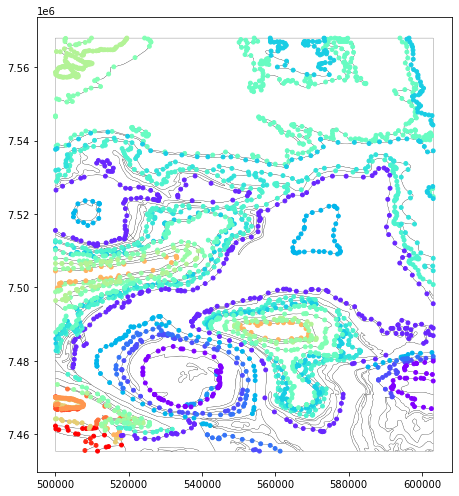

In [36]:
contacts=gpd.read_file(tmp_path+'basal_contacts.shp')

m2l_geometry.save_basal_contacts_csv(contacts,output_path,dtm,dtb,dtb_null,workflow['cover_map'],contact_decimate,c_l)

m2l_utils.plot_points(output_path+'contacts4.csv',geol_clip, 'formation','X','Y',False)


## New interpolation test
Interpolates a regular grid of orientations from an  shapefile of arbitrarily-located points and saves out four csv files of l,m & n direction cosines and dip dip direction data

Can choose between various RBF and IDW options   
  
The purpose of these interpolations and associated code is to help in three cases:
- Providing estimated dips and contacts in fault-bounded domains where no structural data are available
- Needed to estimate true thickness of formations
- Possibly useful for populating parts of maps where little structural data is available

In [37]:
basal_contacts=tmp_path+'basal_contacts.shp'

orientation_interp,contact_interp,combo_interp=m2l_interpolation.interpolation_grids(geology_file,structure_file,basal_contacts,bbox,spacing,dst_crs,scheme,super_groups,c_l)


f=open(tmp_path+'interpolated_orientations.csv','w')
f.write('X,Y,l,m,n,dip,dip_dir\n')
for row in orientation_interp:
    ostr='{},{},{},{},{},{},{}\n'.format(row[0],row[1],row[2],row[3],row[4],row[5],row[6])
    f.write(ostr)
f.close()
f=open(tmp_path+'interpolated_contacts.csv','w')
f.write('X,Y,l,m,angle\n')
for row in contact_interp:
    ostr='{},{},{},{},{}\n'.format(row[0],row[1],row[2],row[3],row[4])
    f.write(ostr)
f.close()
f=open(tmp_path+'interpolated_combined.csv','w')
f.write('X,Y,l,m,n,dip,dip_dir\n')
for row in combo_interp:
    ostr='{},{},{},{},{},{},{}\n'.format(row[0],row[1],row[2],row[3],row[4],row[5],row[6])
    f.write(ostr)
f.close()


['A-mgn-PRK'] have no structures
['A-mgn-PRK'] have no contacts
['A-s-PRK'] have no structures
['A-s-PRK'] have no contacts
['A-b-PRK'] have no structures
['A-b-PRK'] have no contacts


C:\Users\00073294\AppData\Roaming\Python\Python36\site-packages\map2loop-0.0.50-py3.6.egg\map2loop\m2l_interpolation.py:1469: RuntimeWarning: invalid value encountered in true_divide
C:\Users\00073294\AppData\Roaming\Python\Python36\site-packages\map2loop-0.0.50-py3.6.egg\map2loop\m2l_interpolation.py:1470: RuntimeWarning: invalid value encountered in true_divide


206 226
interpolated dips


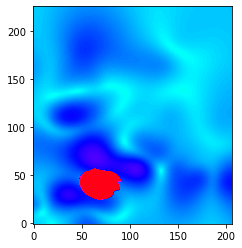

In [38]:
x=int((bbox[2]-bbox[0])/spacing)+1
y=int((bbox[3]-bbox[1])/spacing)+1
print(x,y)
dip_grid=np.ones((y,x))
dip_grid=dip_grid*-999
dip_dir_grid=np.ones((y,x))
dip_dir_grid=dip_dir_grid*-999
contact_grid=np.ones((y,x))
contact_grid=dip_dir_grid*-999
for row in combo_interp:
    r=int((row[1]-bbox[1])/spacing)
    c=int((row[0]-bbox[0])/spacing)
    dip_grid[r,c]=float(row[5])
    dip_dir_grid[r,c]=float(row[6])

for row in contact_interp:
    r=int((row[1]-bbox[1])/spacing)
    c=int((row[0]-bbox[0])/spacing)
    contact_grid[r,c]=float(row[4])

print('interpolated dips')
plt.imshow(dip_grid, cmap="hsv",origin='lower',vmin=-90,vmax=90)  
plt.show()

interpolated dip directions


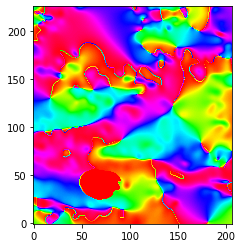

In [39]:
print('interpolated dip directions')
       
plt.imshow(dip_dir_grid, cmap="hsv",origin='lower',vmin=0,vmax=360)    
plt.show()

interpolated contacts


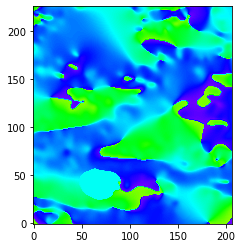

In [40]:
print('interpolated contacts')
       
plt.imshow(contact_grid, cmap="hsv",origin='lower',vmin=-360,vmax=360)    
plt.show()

## Process fault geometry
Save Faults as decimated points and representative orientation  
Then, for each  fault string:
- incementally advance along polyline every at each inter-node (no point in doing more?)
- find local stratigraphy 10m to left and right of fault
  
Once full fault has been traversed:
- Find list of contacts left 
- Find equivalent contacts on right
- use interpolated orientations to estimate minimum true offset assuming vertical displacement and store 
- if no equivalent found, flag as domain fault and find min strat offset for contact, use cumulative minimum thickness estimate and store with flag (not implemented)
- estimate median & sd of minimum fault offset and store with flag (not implemented)

Local Orientations
Since much of the code is the same, we benefit by calculating local orientation data either side of fault so that geomodeller/gempy have satisfied fault compartment orientation data## Save fault as contact info and and orientation info make vertical (for the moment)

In [41]:
m2l_geometry.save_faults(tmp_path+'faults_clip.shp',output_path,dtm,dtb,dtb_null,workflow['cover_map'],c_l,fault_decimate,min_fault_length,fault_dip)


fault orientations saved as ../test_data3/output/fault_orientations.csv
fault positions saved as ../test_data3/output/faults.csv
fault dimensions saved as ../test_data3/output/fault_dimensions.csv


fault displacement estimates saved as ../test_data3/output/fault_displacements3.csv
near-fault orientations saved as ../test_data3/tmp/ex_f_combo_full.csv
near-fault orientations saved as ../test_data3/tmp/ex_f_combo_full.csv


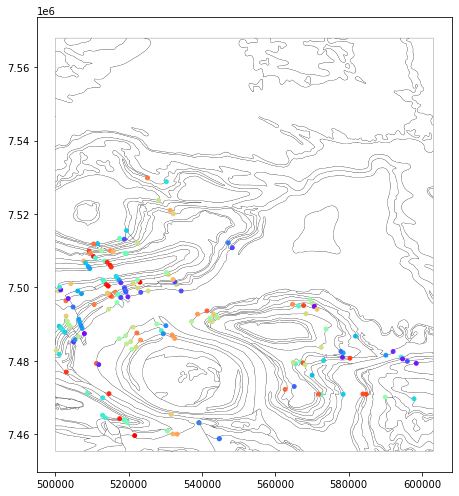

In [42]:
import warnings
warnings.filterwarnings('ignore')

faults=pd.read_csv(output_path+'faults.csv')
faults_len=len(faults)

if(faults_len>0):
    m2l_interpolation.process_fault_throw_and_near_faults_from_grid(tmp_path,output_path,dtm_reproj_file,dtb,dtb_null,workflow['cover_map'],c_l,dst_crs,bbox,
                                                                scheme,dip_grid,dip_dir_grid,x,y,spacing)

    m2l_utils.plot_points(output_path+'fault_displacements3.csv',geol_clip, 'apparent_displacement','X','Y',False)


## Process plutons

For each instruve but not sill polygon, find older neighbours and store decimated contact points. Also store dipping contact orientations (user defined, just because) with four possible sub-surface configurations:

<b>saucers: \\_+++_/ <br>
batholiths: +++/__ __ _\\+++  <br> 
domes: /‾+++‾\\ <br>
pendants: +++\\_  _/+++ <br>
</b>
  
Saves out orientations and contact points, as well as updated group level stratigraphic column.<br>


In [43]:
bbox=(minx,miny,maxx,maxy)

pluton_dip=str(pluton_dip)

dist_buffer=10

m2l_geometry.process_plutons(tmp_path,output_path,geol_clip,local_paths,dtm,dtb,dtb_null,workflow['cover_map'],pluton_form,pluton_dip,contact_decimate,c_l)



0 Wyloo_Group
1 Shingle_Creek_Group
2 Turee_Creek_Group
3 Hamersley_Group
4 Fortescue_Group
5 A_s_PMI
6 A_mgn_PMI
7 A_mgn_PRK
8 A_s_PRK
9 A_b_PRK
pluton contacts and orientations saved as:
../test_data3/output/ign_contacts.csv
../test_data3/output/ign_orientations_domes.csv


## Extract faults and basal contacts of groups from seismic section

In [44]:
if(workflow['seismic_section']):
    seismic_line_file=data_path+'seismic_line_10GA-CP1_rev.shp'   #input geology file (if local)
    seismic_line = gpd.read_file(seismic_line_file) #import map
    seismic_line.plot(figsize=(10,10),edgecolor='#000000',linewidth=0.2) #display map
    display(seismic_line)


    seismic_bbox_file=data_path+'seismic_bbox.shp'   #input geology file (if local)
    seismic_bbox = gpd.read_file(seismic_bbox_file) #import map
    seismic_bbox.set_index('POSITION',inplace=True)

    seismic_interp_file=data_path+'seismic_interp.shp'   #input geology file (if local)
    seismic_interp = gpd.read_file(seismic_interp_file) #import map
    seismic_interp.plot(column='FEATURE',figsize=(10,10),edgecolor='#000000',linewidth=0.5) #display map
    display(seismic_interp)

    surface_cut=2000

    m2l_geometry.extract_section(tmp_path,output_path,seismic_line,seismic_bbox,seismic_interp,dtm,dtb,dtb_null,workflow['cover_map'],surface_cut)

    contacts=pd.read_csv(output_path+'contacts4.csv',",")
    seismic_contacts=pd.read_csv(output_path+'seismic_base.csv',",")
    all_contacts=pd.concat([contacts,seismic_contacts],sort=False)
    all_contacts.to_csv (output_path+'contacts4.csv', index = None, header=True)

    faults=pd.read_csv(output_path+'faults.csv',",")
    seismic_faults=pd.read_csv(output_path+'seismic_faults.csv',",")
    all_faults=pd.concat([faults,seismic_faults],sort=False)
    all_faults.to_csv (output_path+'faults.csv', index = None, header=True)


## Propagate dips along contacts


In [45]:
if(workflow['contact_dips']):
    orientations=pd.read_csv(output_path+'orientations.csv',",")
    contact_dip=-999
    contact_orientation_decimate=5
    m2l_geometry.save_basal_contacts_orientations_csv(contacts,orientations,geol_clip,tmp_path,output_path,dtm,dtb,
                            dtb_null,workflow['cover_map'],contact_orientation_decimate,c_l,contact_dip,dip_grid,spacing,bbox)

## Estimate formation thickness and normalised formation thickness

In [46]:
if(workflow['formation_thickness']):

    geology_file=tmp_path+'basal_contacts.shp'
    contact_decimate=5
    null_scheme='null'
    m2l_interpolation.save_contact_vectors(geology_file,tmp_path,dtm,dtb,dtb_null,workflow['cover_map'],bbox,c_l,null_scheme,contact_decimate)
    
    buffer =5000
    max_thickness_allowed=10000

    m2l_geometry.calc_thickness_with_grid(tmp_path,output_path,buffer,max_thickness_allowed,
                                          c_l,bbox,dip_grid,dip_dir_grid,x,y,spacing)
    m2l_geometry.normalise_thickness(output_path)
    
    m2l_utils.plot_points(output_path+'formation_thicknesses_norm.csv',geol_clip,'norm_th','x','y',False)


## Creates fold axial trace points

In [47]:
if(workflow['fold_axial_traces']   and len(folds_clip)>0):

    m2l_geometry.save_fold_axial_traces(tmp_path+'folds_clip.shp',output_path,dtm,dtb,dtb_null,workflow['cover_map'],c_l,fold_decimate)

    #Save fold axial trace near-hinge orientations
    fat_step=750         # how much to step out normal to fold axial trace
    close_dip=-999       #dip to assign to all new orientations (-999= use local interpolated dip)

    m2l_geometry.save_fold_axial_traces_orientations(tmp_path+'folds_clip.shp',output_path,tmp_path,dtm,dtb,dtb_null,workflow['cover_map'],c_l,dst_crs,
                                                     fold_decimate,fat_step,close_dip,scheme,bbox,spacing,dip_grid,dip_dir_grid)


fold axial traces saved as ../test_data3/output/fold_axial_traces.csv
fold axial traces saved as ../test_data3/output/fold_axial_traces.csv
fold axial trace orientations saved as ../test_data3/output/fold_axial_trace_orientations.csv


## Preprocess data to ensure it meets modelling requirements

In [48]:
m2l_geometry.tidy_data(output_path,tmp_path,use_gcode3,use_interpolations,use_fat,pluton_form,inputs,workflow)
dtm.close()
if(workflow['cover_map']):
    dtb.close()

No interpolated orientations available for merging.


## Calculate polarity of original bedding orientation data (not used yet in final calc)

In [49]:
if(workflow['polarity']):
    m2l_geometry.save_orientations_with_polarity(output_path+'orientations.csv',output_path,c_l,tmp_path+'basal_contacts.shp',tmp_path+'all_sorts.csv',)

    m2l_utils.plot_points(output_path+'orientations_polarity.csv',geol_clip,'polarity','X','Y',True)


## Calculate minimum fault offset from stratigraphy and stratigraphic fault offset

In [50]:
if(workflow['strat_offset']):
    m2l_geometry.fault_strat_offset(output_path,c_l,dst_crs,output_path+'formation_summary_thicknesses.csv', tmp_path+'all_sorts.csv',tmp_path+'faults_clip.shp',tmp_path+'geol_clip.shp',output_path+'fault_dimensions.csv')


    m2l_utils.plot_points(output_path+'fault_strat_offset3.csv',geol_clip,'min_offset','X','Y',True)
    m2l_utils.plot_points(output_path+'fault_strat_offset3.csv',geol_clip,'strat_offset','X','Y',True)


## Analyse fault-fault topology

cycles [['Fault_313', 'Fault_2837', 'Fault_16825', 'Fault_7966']]


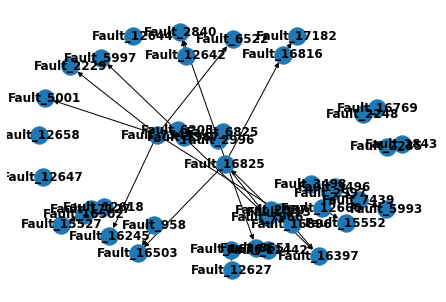

In [51]:
m2l_topology.parse_fault_relationships(graph_path,tmp_path,output_path)

# loop2gemodeller test 



In [52]:
if(workflow['model_engine']=='geomodeller'):
    from datetime import datetime
    import shutil

    
    m2l_topology.check_near_fault_contacts(tmp_path+'faults_clip.shp',tmp_path+'all_sorts_clean.csv',
                                           output_path+'fault_dimensions.csv',output_path+'group-fault-relationships.csv',
                                           output_path+'contacts_clean.csv',c_l,dst_crs)

    nowtime=datetime.now().isoformat(timespec='minutes')   
    model_name=test_data_name+'_'+nowtime.replace(":","-").replace("T","-")
    os.mkdir(test_data_path+'/'+model_name)
    save_faults=True
    compute_etc=True
    t1 = time.time()
    m2l_export.loop2geomodeller(model_name,test_data_path,tmp_path,output_path,'../dtm/dtm_rp.tif',bbox,
                                model_top,model_base,save_faults,compute_etc,workflow)
    t2 = time.time()
    os.chdir(test_data_path+'/'+model_name)
    %system geomodellerbatch.exe -batch m2l.taskfile
    t3 = time.time()
    #%system geomodellerbatch.exe -batch m2l_compute.taskfile
    t4 = time.time()
    print("m2l",(t1-t0)/60.0,"export process",(t2-t1)/60.0,"batch process",(t3-t2)/60.0,"batch calculate",(t4-t3)/60.0,"minutes")
    #shutil.copy('../tmp','.')
    #shutil.copy('../output','.')
    #shutil.copy('../graph','.')
    #shutil.copy('../dtm','.')
    os.chdir('..')

# loopstructural test

In [53]:
if(workflow['model_engine']=='loopstructural'):
    f=open(tmp_path+'bbox.csv','w')
    f.write('minx,miny,maxx,maxy,lower,upper\n')
    ostr='{},{},{},{},{},{}\n'.format(minx,miny,maxx,maxy,model_base,model_top)
    f.write(ostr)
    f.close()
    t1 = time.time()
    import lavavu
    from pyamg import solve

    m2l_export.loop2LoopStructural(output_path+'formation_thicknesses.csv',output_path+'orientations.csv',output_path+'contacts4.csv',tmp_path,bbox)
    t2 = time.time()
    print("m2l",(t1-t0)/60.0,"LoopStructural",(t2-t1)/60.0,"Total",(t2-t0)/60.0,"minutes")

# gempy test

In [14]:
if(workflow['model_engine']=='gempy'):

    t1 = time.time()
    import importlib
    importlib.reload(m2l_export)


    vtk=False
    m2l_export.loop2gempy(test_data_name,tmp_path,vtk_path,output_path+'orientations_clean.csv',
                                    output_path+'contacts_clean.csv',tmp_path+'groups_clean.csv',
                                    bbox,model_base, model_top,vtk,dtm_reproj_file)


You can find the C code in this temporary file: C:\Users\00073294\AppData\Local\Temp\theano_compilation_error_4ub6c46o


Exception: Compilation failed (return status=1): In file included from C:/msys64/mingw64/include/c++/9.1.0/math.h:36,.                  from C:\Users\00073294\Anaconda3\envs\loop\include/pyport.h:194,.                  from C:\Users\00073294\Anaconda3\envs\loop\include/Python.h:53,.                  from C:\Users\00073294\AppData\Local\Theano\compiledir_Windows-10-10.0.17134-SP0-Intel64_Family_6_Model_142_Stepping_10_GenuineIntel-3.6.10-64\lazylinker_ext\mod.cpp:1:. C:/msys64/mingw64/include/c++/9.1.0/cmath:1121:11: error: '::hypot' has not been declared.  1121 |   using ::hypot;.       |           ^~~~~. In file included from c:\users\00073294\anaconda3\envs\loop\lib\site-packages\numpy\core\include/numpy/npy_3kcompat.h:22,.                  from C:\Users\00073294\AppData\Local\Theano\compiledir_Windows-10-10.0.17134-SP0-Intel64_Family_6_Model_142_Stepping_10_GenuineIntel-3.6.10-64\lazylinker_ext\mod.cpp:7:. c:\users\00073294\anaconda3\envs\loop\lib\site-packages\numpy\core\include/numpy/npy_common.h:168:20: warning: 'int _fseeki64(FILE*, long long int, int)' redeclared without dllimport attribute: previous dllimport ignored [-Wattributes].   168 | extern int __cdecl _fseeki64(FILE *, long long, int);.       |                    ^~~~~~~~~. c:\users\00073294\anaconda3\envs\loop\lib\site-packages\numpy\core\include/numpy/npy_common.h:169:26: warning: 'long long int _ftelli64(FILE*)' redeclared without dllimport attribute: previous dllimport ignored [-Wattributes].   169 | extern long long __cdecl _ftelli64(FILE *);.       |                          ^~~~~~~~~. 

# noddy test

In [ ]:
if(workflow['model_engine']=='noddy'):

    import pynoddy.history
    import networkx as nx
    #Read a csv file with the vertices of the faults
    #see notes in the bottom of the notebook for instructions on how to generate such vertices files
    t1 = time.time()
    
    scale=1.5 #  scales mdoel to fit predefined volume (complete hack)
    
    # load fault coordinates
    faultsxy=pd.read_csv(output_path+'faults.csv')

    #load fault graph, remove cyclic loops and find (non-unique) age-ordered list 
    G=nx.read_gml(tmp_path+"fault_network.gml")
    cycles=list(nx.simple_cycles(G))
    for c in cycles:
        G.remove_edge(c[0], c[1])
    faults=nx.topological_sort(G)

    # write out Noe format format file
    file=open(tmp_path+'faults_for_noe.csv','w')
    file.write('id,DipDirecti,X,Y\n')
    for f in faults:
            fxy=faultsxy[faultsxy["formation"]==f.replace("\n","")]
            #display(f.replace("\n",""))
            for ind,xy in fxy.iterrows():
                ostr=f.replace('\n','')+',West,'+str(xy['X']/scale)+','+str(xy['Y']/scale)+'\n'
                file.write(ostr)
    file.close()
    
    csvfile = tmp_path+'faults_for_noe.csv'
    CsvFaultData = pd.read_csv(csvfile)

    #how much does the fault slip relative to the fault length
    SlipParam = 0.1

    #the xyz origin of the model you will be generating
    xy_origin=[minx/scale,miny/scale, 1200-4000]

    #Get information about each parameter in Noddy format
    #The output from the function is a dictionary with lists of the fault parameters
    noddyFormattedFaultData =  pynoddy.history.setUpFaultRepresentation(CsvFaultData,
                                                        xy_origin=xy_origin, 
                                                        SlipParam=SlipParam)

    #Create a dictionary with the stratigraphy information
    StratDict = {}
    StratDict['Heights'] = [2000, 2500, 3000, 3700]
    StratDict['Names'] = ['Intrusive', 'Felsic', 'Mafic','Sed'] 
    StratDict['Density'] =  [2.65, 2.5, 2.4, 2.3] 
    StratDict['MagSus'] = [0.0015, 0.0012, 0.0018, 0.001]

    #Now make the history file
    filename = output_path+'faultmodel.his'
    noddyFormattedFaultData =  pynoddy.history.createPyNoddyHistoryFile(noddyFormattedFaultData, StratDict, filename=filename)


In [ ]:
if(workflow['model_engine']=='noddy'):
    import vtkplotter as vtkP
    import itkwidgets
    import k3d
    import pynoddy.output
    import pynoddy.history

    modelfile = output_path+'faultmodel.his'

    # Determine the path to the noddy executable
    noddy_path = '../../pynoddy-new/noddyapp/noddy_win64.exe'

    # Where you would like to place all your output files
    outputfolder = tmp_path

    # choose what software to use for visualizing the model
    #you can also choose to change to itkwidgets, k3d, False (popup), or panel
    #you might need to install packages depending on what you choose
    vtkP.settings.embedWindow('k3d') 

    # create a plot in vtkplotter
    plot = vtkP.Plotter(axes=1, bg='white', interactive=1)

    # call the plotting function
    points = pynoddy.output.CalculatePlotStructure(modelfile, plot, noddy_path, 
                                           outputfolder=outputfolder,
                                           LithologyOpacity=0.2, outputOption=0)
    plot.show(viewup='z')
    t2 = time.time()

    print("m2l",(t1-t0)/60.0,"noddy",(t2-t1)/60.0,"Total",(t2-t0)/60.0,"minutes")
